In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

In [47]:
freqs = [5, 11, 20, 30, 40, 50, 60]
bias_by_freq = [-0.3, -0.359, -0.48, -0.628, -0.83, -1.037, -1.2]

def get_bias(hall_freq):
    """
    Finds the closest frequency in the list and returns the associated bias
    """
    closest = min(freqs, key=lambda x: abs(x-hall_freq))
    return bias_by_freq[freqs.index(closest)]

In [48]:
# Define the low pass filter
cutoff_freq = 0.17
sampling_freq = 4.10

def lowpass_filter(dataframe):
    b, a = butter(5, 2*cutoff_freq/sampling_freq, btype='low', analog=False)
    return filtfilt(b, a, dataframe)

In [58]:
files = []
freqs = [5,11,20,30,40,50,60]
for f in freqs:
    if f==30 or f==20:
        files.append(f'flow_data/about_{f}/about_{f}_hz1.csv')
    elif f==11:   
        files.append(f'flow_data/about_{f}/about{f}_hz.csv')
    else:
        files.append(f'flow_data/about_{f}/about_{f}_hz.csv')

files

['flow_data/about_5/about_5_hz.csv',
 'flow_data/about_11/about11_hz.csv',
 'flow_data/about_20/about_20_hz1.csv',
 'flow_data/about_30/about_30_hz1.csv',
 'flow_data/about_40/about_40_hz.csv',
 'flow_data/about_50/about_50_hz.csv',
 'flow_data/about_60/about_60_hz.csv']

Dropped one row.


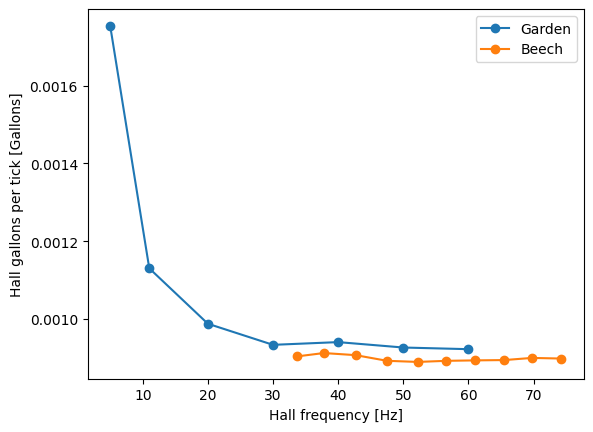

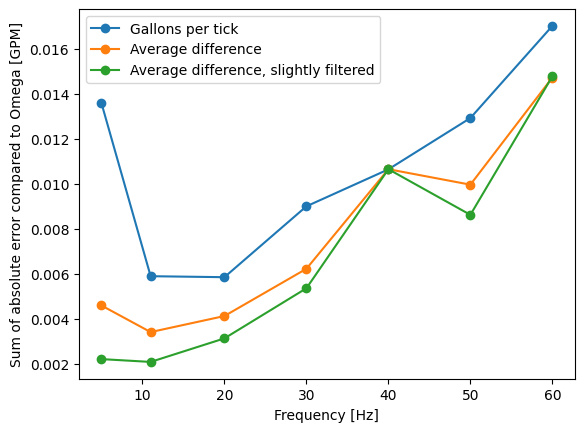

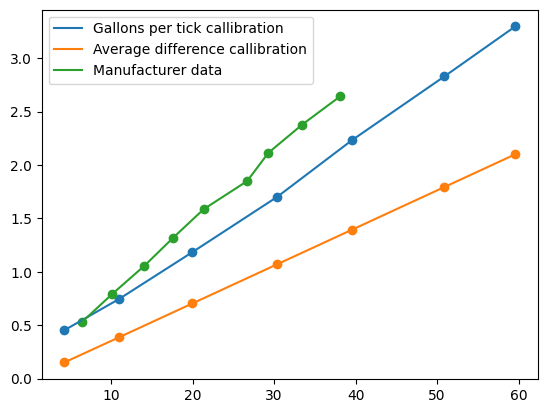

In [59]:
# Want to get GPM as a function of the frequency with omega callibration (gallons per tick)

GPT = []
GPM_true = []
GPM_gpt = []
fs = []

gpt_list = []

error_bias = []
error_gpt = []
error_filter = []

for file_path in files:

    df = pd.read_csv(file_path).iloc[50:-50]
    df['time'] = df.index
    df['sensor'] = df['Timestamp (unix time nano seconds)'].str.replace(' ', '')
    df = df[['time', 'sensor']]
    df = df.reset_index(drop=True)

    # Remove double counts on Omega
    previous_omega_index = -10
    for index, row in df[df.sensor=='Omega'].iterrows():
        if index-previous_omega_index < 5:
            print('Dropped one row.')
            df.drop(index, inplace=True)
        previous_omega_index = index       

    # Crop between the first and last Omega ticks
    first_omega_tick = list(df[df.sensor=='Omega'].index)[0]
    last_omega_tick = list(df[df.sensor=='Omega'].index)[-1]
    df = df.iloc[first_omega_tick:last_omega_tick+1]

    # Count the number of Omega ticks to find number of gallons
    gallons = len(df[df.sensor=='Omega'])*0.1 - 0.1

    # Get the number of gallons per tick using the Hall sensor
    hall_gallons_per_tick = gallons / len(df[df.sensor=='Hall'])
    
    # Compute GPMs
    omega_times = list(df[df.sensor=='Omega'].time)
    hall_times = list(df[df.sensor=='Hall'].time)

    for i in range(len(omega_times)-1):
        frequency = 1/(omega_times[i+1]-omega_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'omega_freq'] = frequency
            df.loc[df.time>=0, 'omega_GPM'] = 0.1*frequency*60
        df.loc[df.time>=omega_times[i], 'omega_freq'] = frequency
        df.loc[df.time>=omega_times[i], 'omega_GPM'] = 0.1*frequency*60

    for i in range(len(hall_times)-1):
        frequency = 1/(hall_times[i+1]-hall_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'hall_freq'] = frequency/2
            df.loc[df.time>=0, 'hall_GPM'] = frequency/7.5 * 0.264172
            df.loc[df.time>=0, 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60
        df.loc[df.time>=hall_times[i], 'hall_freq'] = frequency
        df.loc[df.time>=hall_times[i], 'hall_GPM'] = frequency/7.5 * 0.264172
        df.loc[df.time>=hall_times[i], 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60

    # Remove errors
    df.loc[df['hall_GPM'] > 10, 'hall_GPM'] = np.nan
    df.loc[df['omega_GPM'] > 10, 'omega_GPM'] = np.nan

    # Calibrate using bias correction
    df['bias'] = [get_bias(x) for x in list(df['hall_freq'])]
    df['hall_GPM_bias'] = df.hall_GPM - df.bias

    # Low pass filer
    df['hall_GPM_bias_filtered'] = lowpass_filter(df['hall_GPM_bias'])

    # Compute error relative to Omega
    error_bias.append((df['omega_GPM'] - df['hall_GPM_bias']).abs().sum()/len(df))
    error_gpt.append((df['omega_GPM'] - df['hall_GPM_gpt']).abs().sum()/len(df))
    error_filter.append((df['omega_GPM'] - df['hall_GPM_bias_filtered']).abs().sum()/len(df))

    fs.append(np.mean(df.hall_freq))
    GPT.append(hall_gallons_per_tick)
    GPM_gpt.append(np.mean(df.hall_GPM_gpt))
    GPM_true.append(np.mean(df.hall_GPM))

    gpt_list.append(hall_gallons_per_tick)




# Comparing gallons per tick between garden experiments and beech
freqs2 = [33.711, 37.806, 42.673, 47.514, 52.222, 56.611, 61.076, 65.504, 69.776, 74.238]
ticks2 = [0.0009030961, 0.0009116868, 0.000906298, 0.0008916935, 0.0008888221, 0.0008916298, 0.0008927958, 0.0008936075, 0.0008991244, 0.0008975219]

plt.plot(freqs, gpt_list, '-o', label='Garden')
plt.plot(freqs2, ticks2, '-o', label='Beech')
plt.ylabel('Hall gallons per tick [Gallons]')
plt.xlabel('Hall frequency [Hz]')
plt.legend()
plt.show()




plt.plot(freqs, error_gpt, '-o', label='Gallons per tick')
plt.plot(freqs, error_bias, '-o', label='Average difference')
plt.plot(freqs, error_filter, '-o', label='Average difference, slightly filtered')
plt.ylabel('Sum of absolute error compared to Omega [GPM]')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.show()

# plot GPT for each frequency
# plot GPM for each frequency
plt.plot(fs, GPM_gpt, label='Gallons per tick callibration')
plt.scatter(fs, GPM_gpt)
plt.plot(fs, GPM_true, label='Average difference callibration')
plt.scatter(fs, GPM_true)

f_manufacturer = [12.82, 20.3, 28.2, 35.3, 42.7, 53.4, 58.6, 66.9, 76.2]
f_manufacturer = [x/2 for x in f_manufacturer]
GPM_manufacturer = list(range(2,11))
GPM_manufacturer = [x* 0.264172 for x in GPM_manufacturer]

plt.plot(f_manufacturer, GPM_manufacturer, label = 'Manufacturer data')
plt.scatter(f_manufacturer, GPM_manufacturer)

plt.legend()
plt.show()



In [51]:
def analyse(file_path, nolimit=False):

    df = pd.read_csv(file_path).iloc[50:-50]
    df['time'] = df.index
    df['sensor'] = df['Timestamp (unix time nano seconds)'].str.replace(' ', '')
    df = df[['time', 'sensor']]
    df = df.reset_index(drop=True)

    # Remove double counts on Omega
    previous_omega_index = -10
    for index, row in df[df.sensor=='Omega'].iterrows():
        if index-previous_omega_index < 5:
            print('Dropped one row.')
            df.drop(index, inplace=True)
        previous_omega_index = index       

    # Crop between the first and last Omega ticks
    first_omega_tick = list(df[df.sensor=='Omega'].index)[0]
    last_omega_tick = list(df[df.sensor=='Omega'].index)[-1]
    df = df.iloc[first_omega_tick+1:last_omega_tick+1]

    # Count the number of Omega ticks to find number of gallons
    gallons = len(df[df.sensor=='Omega'])*0.1

    # Get the number of gallons per tick using the Hall sensor
    hall_gallons_per_tick = gallons / len(df[df.sensor=='Hall'])
    print(f'\nGallons per tick: {hall_gallons_per_tick}\n')
    
    # Compute GPMs
    omega_times = list(df[df.sensor=='Omega'].time)
    hall_times = list(df[df.sensor=='Hall'].time)

    for i in range(len(omega_times)-1):
        frequency = 1/(omega_times[i+1]-omega_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'omega_freq'] = frequency
            df.loc[df.time>=0, 'omega_GPM'] = 0.1*frequency*60
        df.loc[df.time>=omega_times[i], 'omega_freq'] = frequency
        df.loc[df.time>=omega_times[i], 'omega_GPM'] = 0.1*frequency*60

    for i in range(len(hall_times)-1):
        frequency = 1/(hall_times[i+1]-hall_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'hall_freq'] = frequency/2
            df.loc[df.time>=0, 'hall_GPM'] = frequency/7.5 * 0.264172
            df.loc[df.time>=0, 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60
        df.loc[df.time>=hall_times[i], 'hall_freq'] = frequency
        df.loc[df.time>=hall_times[i], 'hall_GPM'] = frequency/7.5 * 0.264172
        df.loc[df.time>=hall_times[i], 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60

    # Remove errors
    df.loc[df['hall_GPM'] > 10, 'hall_GPM'] = np.nan
    df.loc[df['omega_GPM'] > 10, 'omega_GPM'] = np.nan

    # Calibrate using bias correction
    df['bias'] = [get_bias(x) for x in list(df['hall_freq'])]
    df['hall_GPM_bias'] = df.hall_GPM - df.bias

    # Low pass filer
    df['hall_GPM_bias_filtered'] = lowpass_filter(df['hall_GPM_bias'])

    # Compute error relative to Omega
    error_bias = round((df['omega_GPM'] - df['hall_GPM_bias']).abs().sum(),4)
    error_gpt = round((df['omega_GPM'] - df['hall_GPM_gpt']).abs().sum(),4)
    error_filter = round((df['omega_GPM'] - df['hall_GPM_bias_filtered']).abs().sum(),4)

    # Plot results
    plt.plot(list(df.time), list(df.omega_GPM), alpha=0.7, label='Omega', color='red')
    plt.plot(list(df.time), list(df.hall_GPM_gpt), alpha=0.3, label=f'Hall gallons per tick, error: {error_gpt}', color='green')
    plt.plot(list(df.time), list(df.hall_GPM_bias), alpha=0.4, label=f'Hall average bias, error: {error_bias}', color='blue')
    plt.plot(list(df.time), list(df.hall_GPM_bias_filtered), alpha=0.7, label=f'Hall average bias, filtered, error: {error_filter}', color='blue')
    plt.title(file_path.split('/')[-1])
    if not nolimit:
        plt.ylim([np.mean(df.omega_GPM)-0.12, np.mean(df.omega_GPM)+0.12])
    #plt.ylim([min(min(list(df.omega_GPM)),min(list(df.hall_GPM)))-0.2, max(max(list(df.omega_GPM)),max(list(df.hall_GPM)))+0.2])
    plt.ylabel('GPM')
    plt.xlabel('Time')
    plt.legend()
    plt.show()


Gallons per tick: 0.0009871668311944718



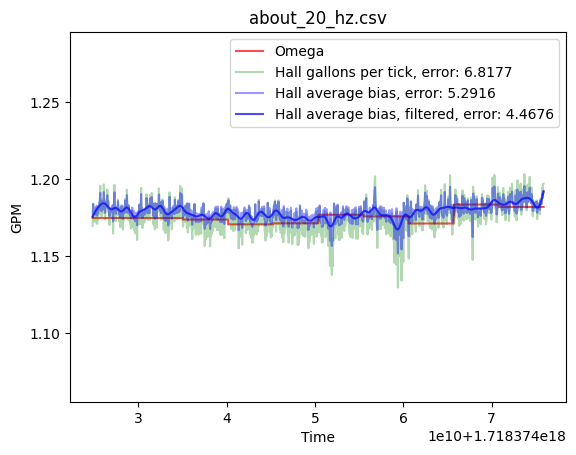

In [57]:
analyse(f'flow_data/about_20/about_20_hz.csv')

**************************************************
Frequency: 5 Hz
**************************************************

Gallons per tick: 0.0017543859649122807


Gallons per tick: 0.0017605633802816902



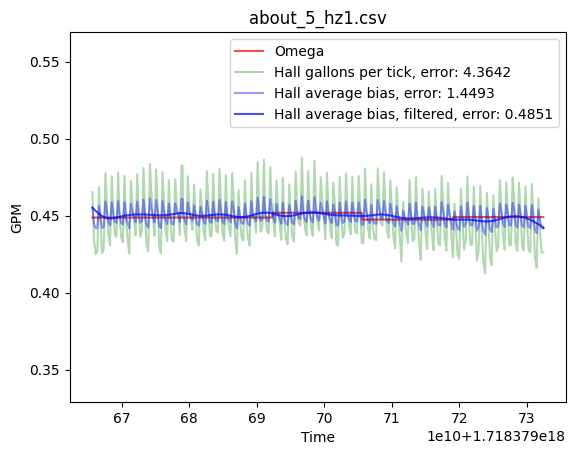


Gallons per tick: 0.0017543859649122807



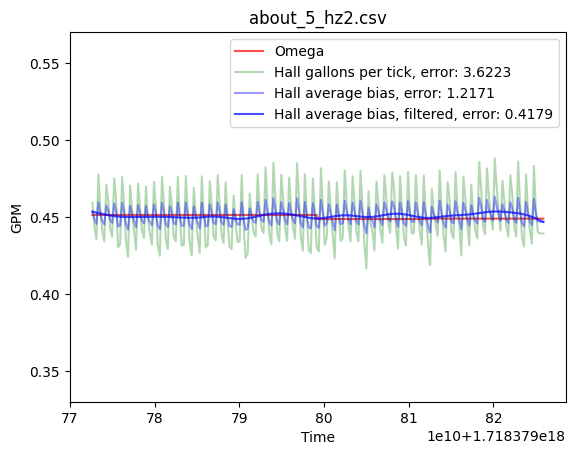


Gallons per tick: 0.0018181818181818182



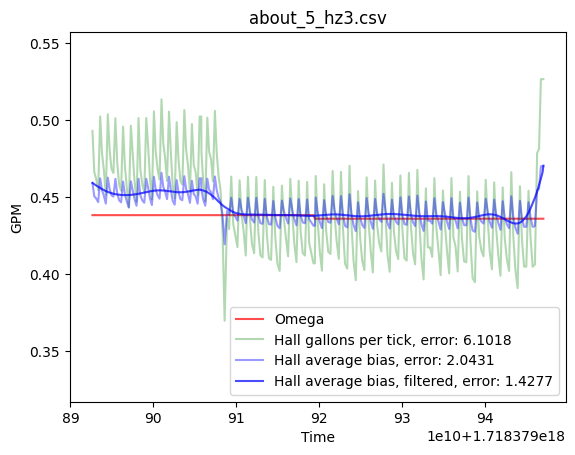


Gallons per tick: 0.0017543859649122807



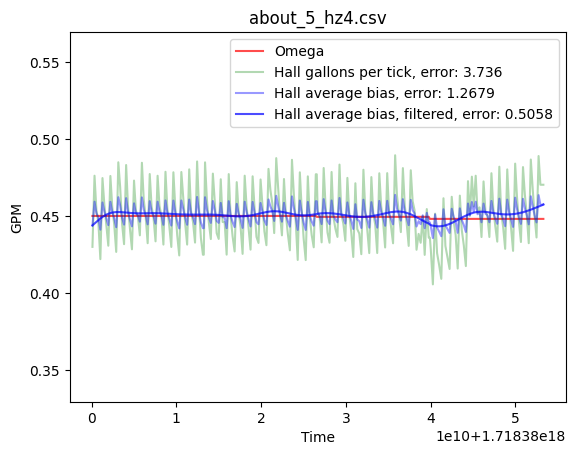

**************************************************
Frequency: 11 Hz
**************************************************

Gallons per tick: 0.001129943502824859



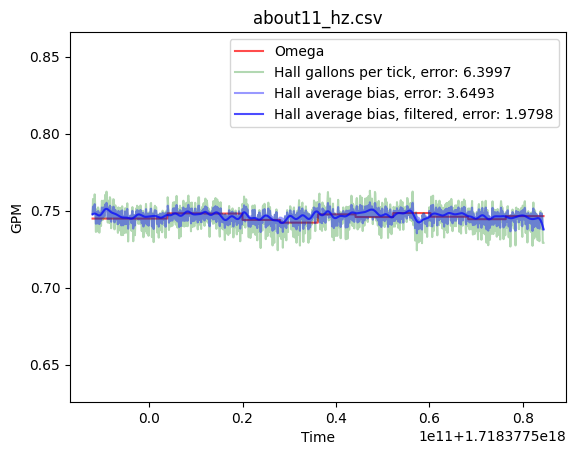


Gallons per tick: 0.0011312217194570137



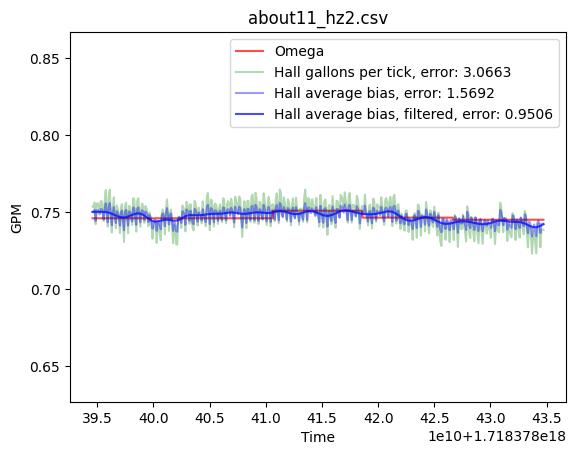


Gallons per tick: 0.0011267605633802818



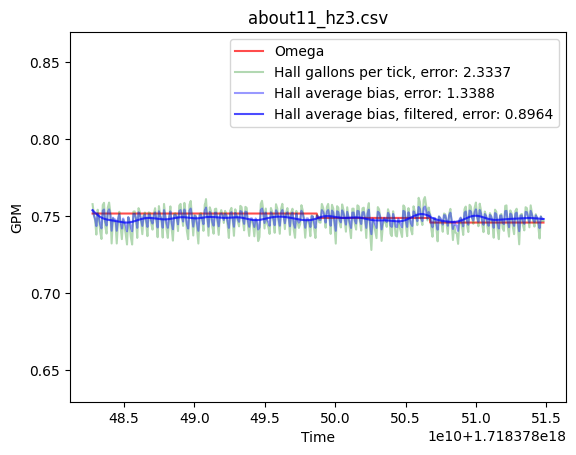


Gallons per tick: 0.001128668171557562



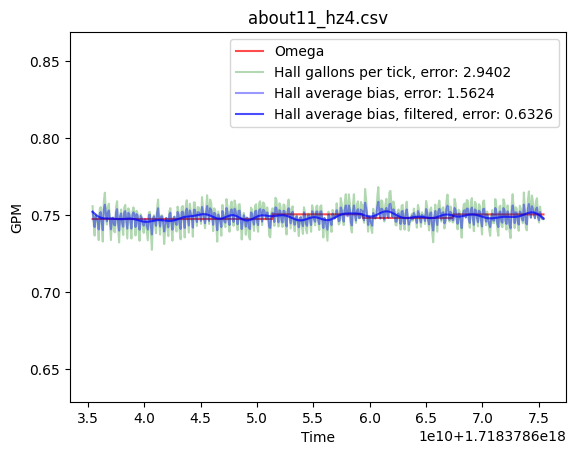

**************************************************
Frequency: 20 Hz
**************************************************

Gallons per tick: 0.0009871668311944718



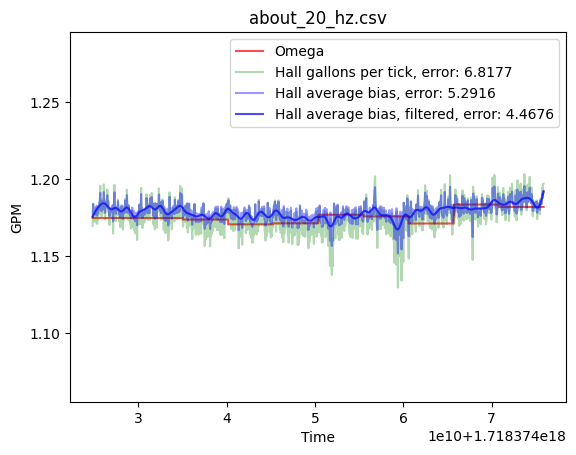

Dropped one row.

Gallons per tick: 0.0009871668311944718



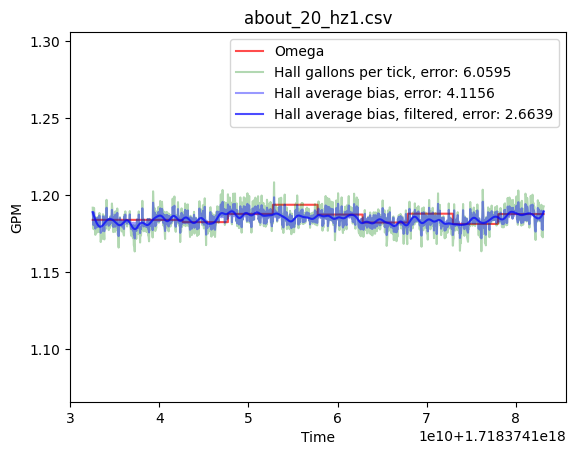


Gallons per tick: 0.0009871668311944718



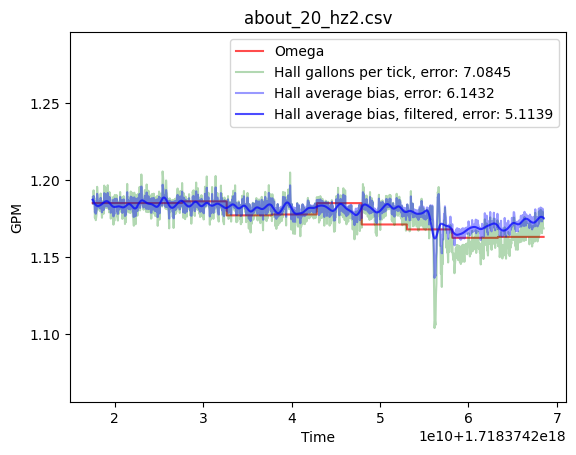


Gallons per tick: 0.0009852216748768472



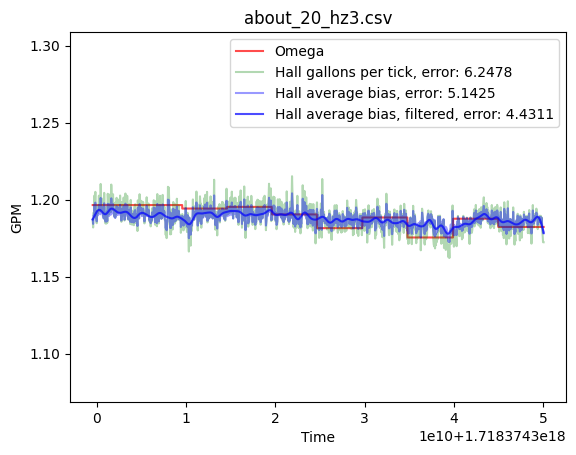


Gallons per tick: 0.000984251968503937



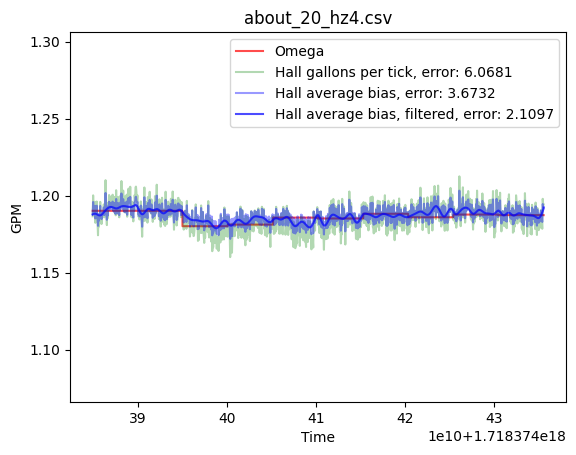

**************************************************
Frequency: 30 Hz
**************************************************

Gallons per tick: 0.0009328358208955224



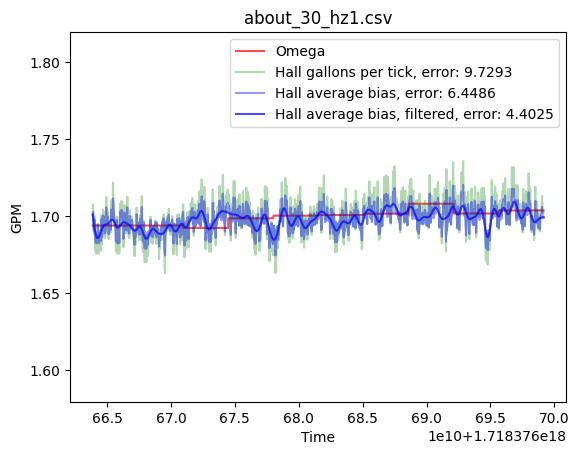


Gallons per tick: 0.0009302325581395349



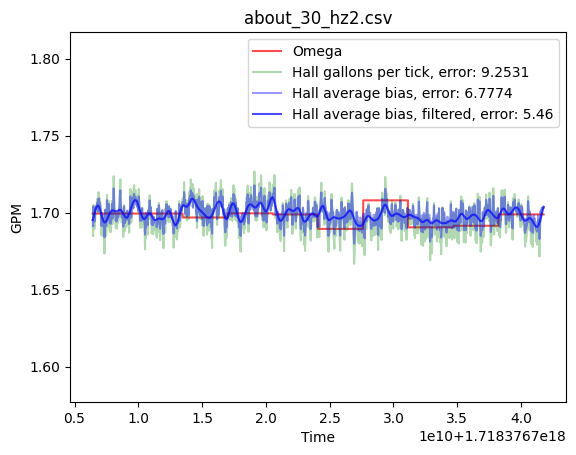


Gallons per tick: 0.0009326424870466321



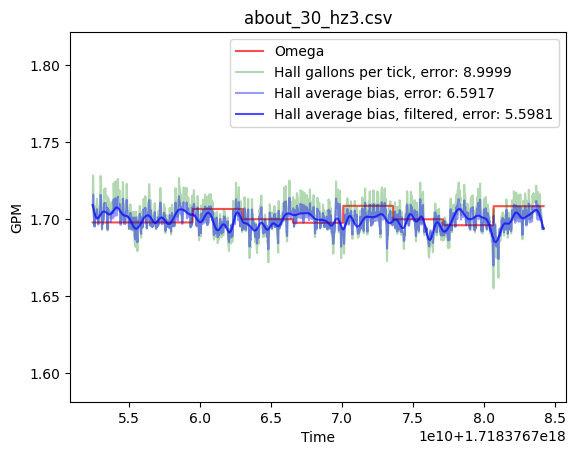


Gallons per tick: 0.000931098696461825



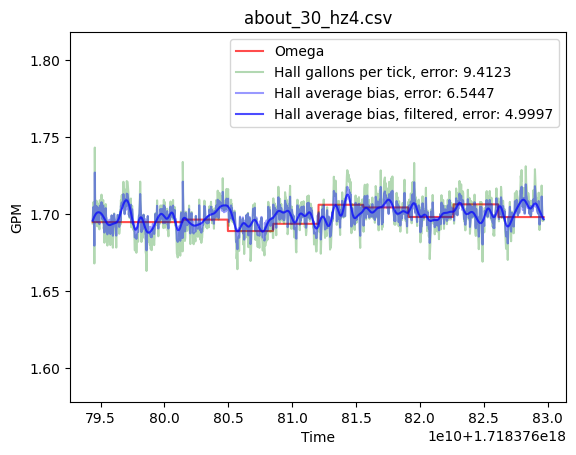

**************************************************
Frequency: 40 Hz
**************************************************

Gallons per tick: 0.0009398496240601503



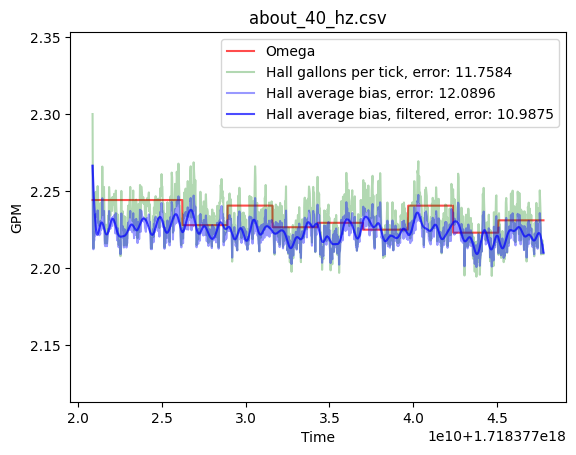


Gallons per tick: 0.0009372071227741331



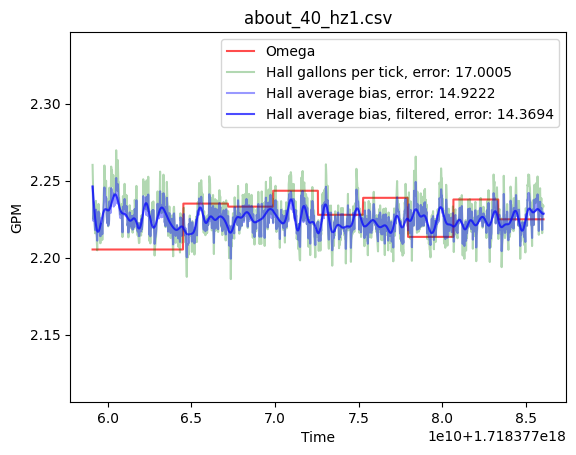


Gallons per tick: 0.0009354536950420954



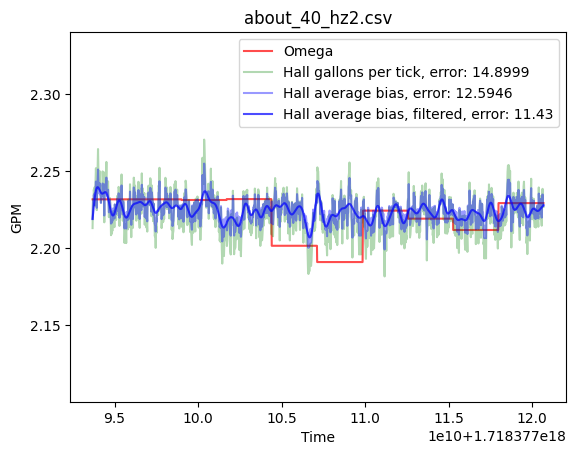


Gallons per tick: 0.000931098696461825



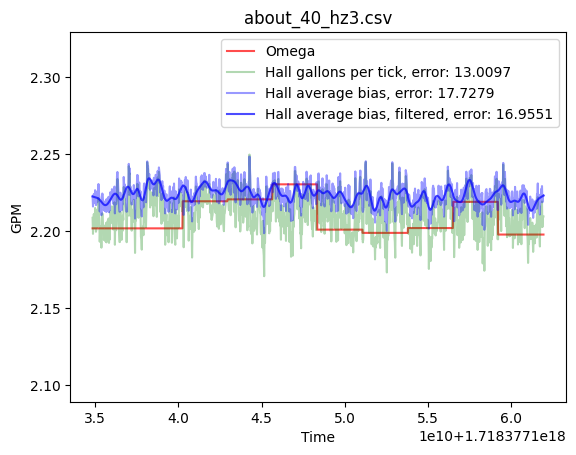


Gallons per tick: 0.0009345794392523365



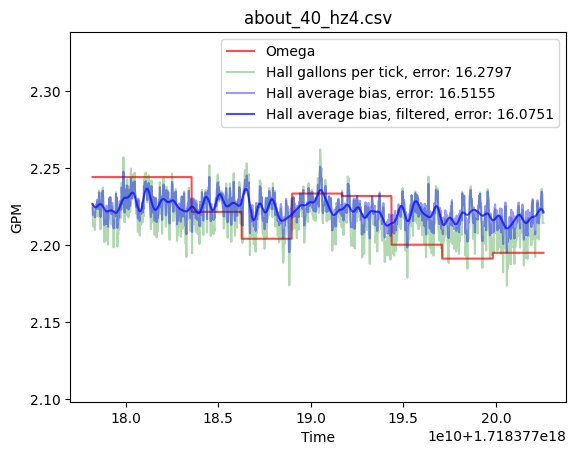

**************************************************
Frequency: 50 Hz
**************************************************

Gallons per tick: 0.000925925925925926



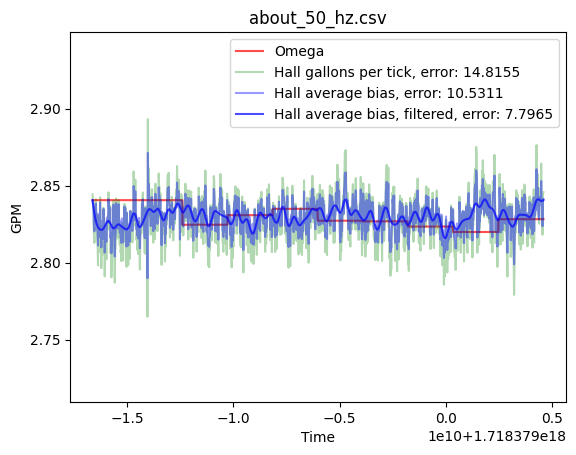


Gallons per tick: 0.0009268795056642636



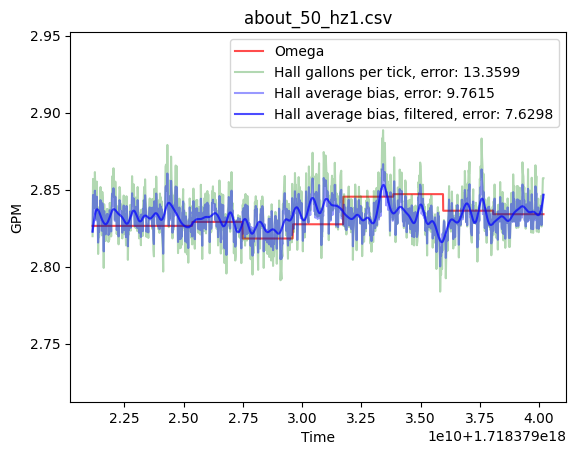


Gallons per tick: 0.0009268795056642636



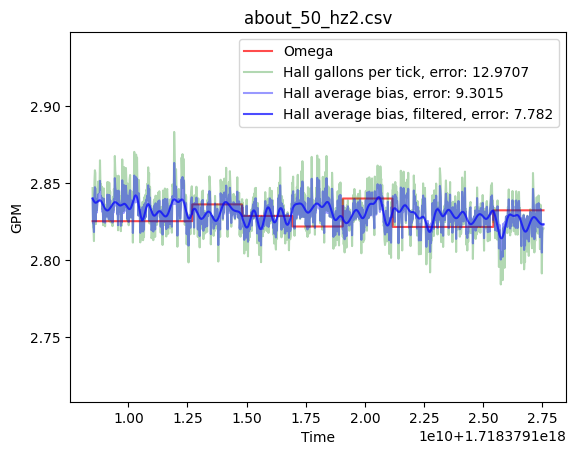


Gallons per tick: 0.000925925925925926



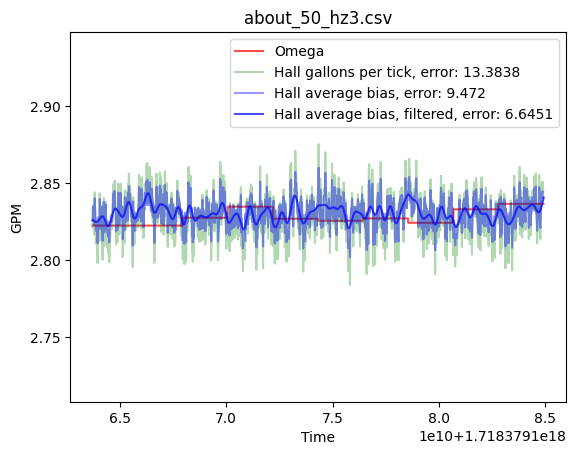


Gallons per tick: 0.0009267840593141798



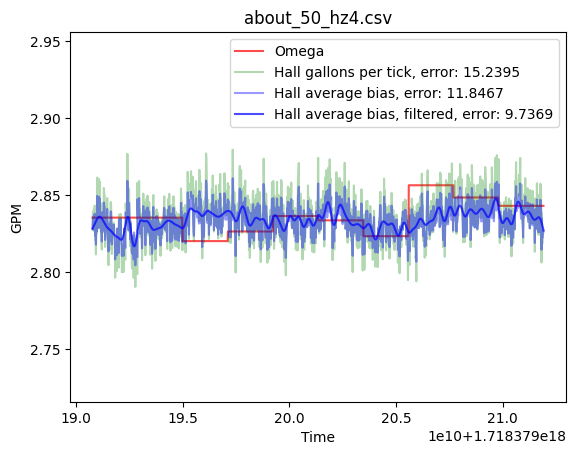

**************************************************
Frequency: 60 Hz
**************************************************

Gallons per tick: 0.0009216589861751152



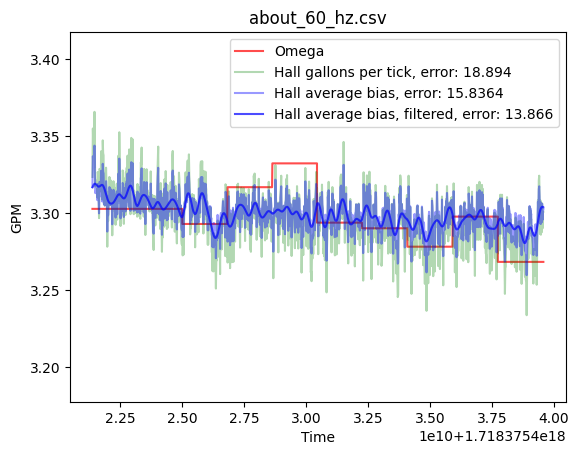


Gallons per tick: 0.0009276437847866419



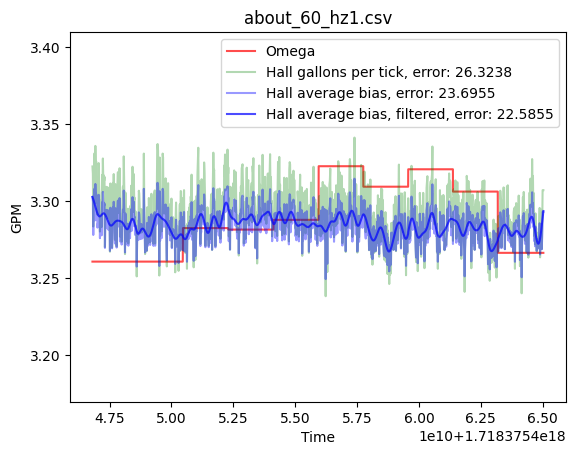


Gallons per tick: 0.0009267840593141798



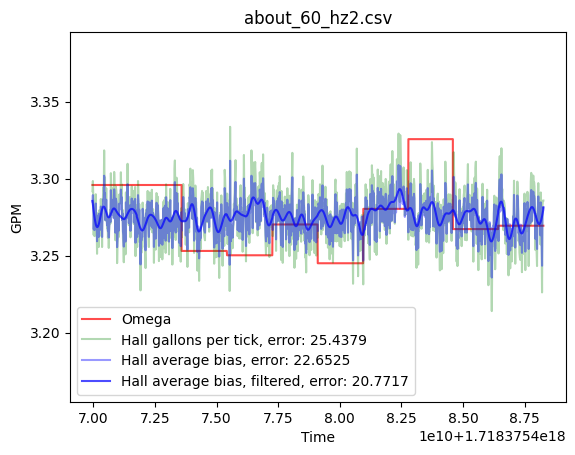


Gallons per tick: 0.0009242144177449168



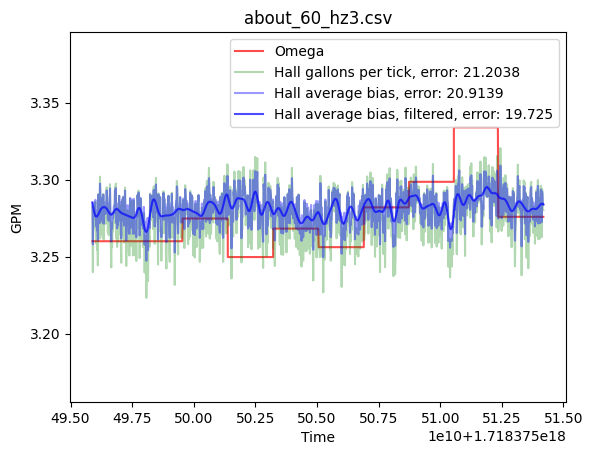


Gallons per tick: 0.0009250693802035153



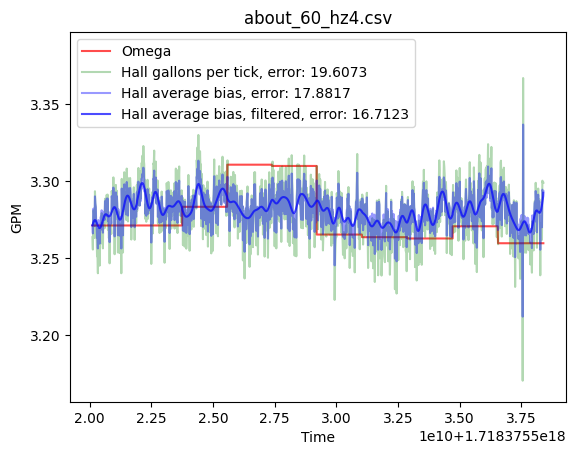

In [53]:
freqs = [5,11,20,30,40,50,60]
for f in freqs:
    print('*'*50)
    print(f'Frequency: {f} Hz')
    print('*'*50)
    for i in range(5):
        try:
            if i>0:
                if f!=11:
                    analyse(f'flow_data/about_{f}/about_{f}_hz{i}.csv')
                else:   
                    analyse(f'flow_data/about_{f}/about{f}_hz{i}.csv')
            elif f!=30:
                if f!=11:
                    analyse(f'flow_data/about_{f}/about_{f}_hz.csv')
                else:   
                    analyse(f'flow_data/about_{f}/about{f}_hz.csv')
        except:
            continue


Gallons per tick: 0.0010027347310847768



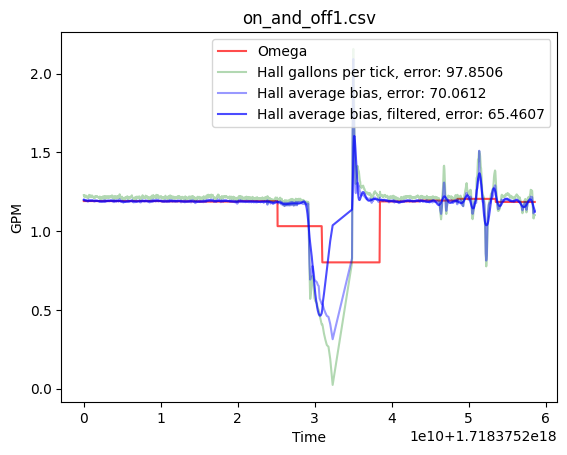


Gallons per tick: 0.0010027347310847768



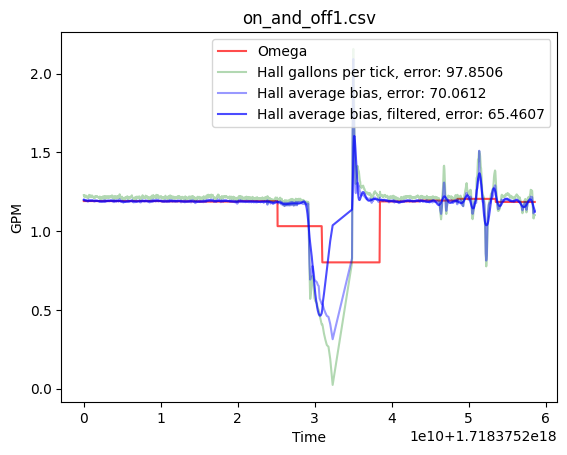


Gallons per tick: 0.0009242144177449168



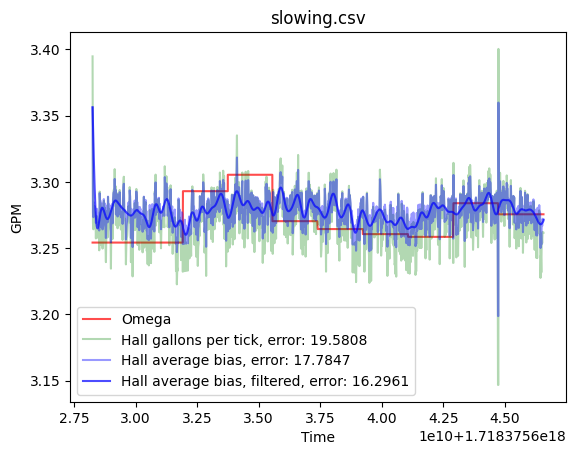


Gallons per tick: 0.0009297520661157025



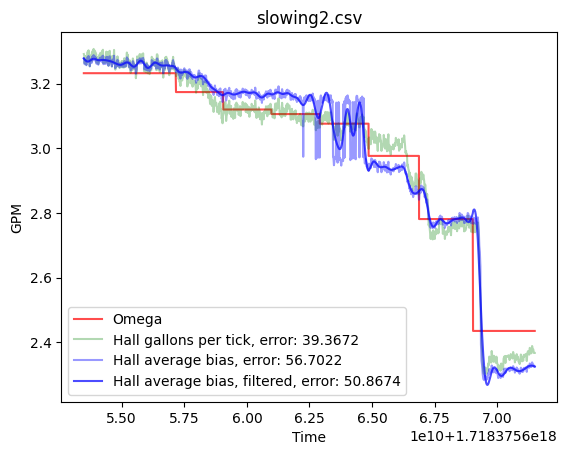

In [54]:
analyse('flow_data/onoff_slow/on_and_off1.csv', nolimit=True)
analyse('flow_data/onoff_slow/on_and_off1.csv', nolimit=True)
analyse('flow_data/onoff_slow/slowing.csv', nolimit=True)
analyse('flow_data/onoff_slow/slowing2.csv', nolimit=True)